In [1]:
import numpy as np
from qiskit import BasicAer
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import Grover
from qiskit.aqua.components.oracles import LogicalExpressionOracle, TruthTableOracle
import random

%matplotlib inline

In [2]:
"""This assumes that the counts are already sorted and as a list"""
def counts_to_probabilities(counts):
    total_counts = sum(counts)
    probabilities = list(map(lambda x: (x/total_counts), counts))
    
    # To make it easier to figure out what result we get, we'll combine
    # values so we can see what's the result
    for i in range(len(probabilities) - 1):
        probabilities[i+1] += probabilities[i]
    
    return probabilities

In [3]:
"""Assumes that the list of probabilities are already combined"""
def random_selection(probabilities, debug=False):
    randomVal = random.random()

    """Logic pulled from https://www.geeksforgeeks.org/python-get-the-index-of-first-element-greater-than-k/"""
    resultingAction = next(x for x, val in enumerate(probabilities) if val > randomVal)
    
    if(debug):
        print(f'{randomVal} yields {resultingAction}')
    
    return resultingAction

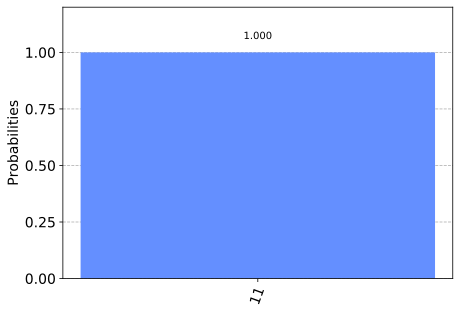

In [13]:
expression = 'a and b'

oracle = LogicalExpressionOracle(expression)
grover = Grover(oracle)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=4048)
result = grover.run(quantum_instance)
#print(result['result'])
plot_histogram(result['measurement'])

In [8]:
from qiskit import IBMQ
provider = IBMQ.load_account()

In [9]:
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmq_ourense')

gates =  OrderedDict([('u2', 9), ('u3', 5), ('barrier', 2), ('measure', 2), ('ccx', 1), ('cx', 1)])
depth =  11


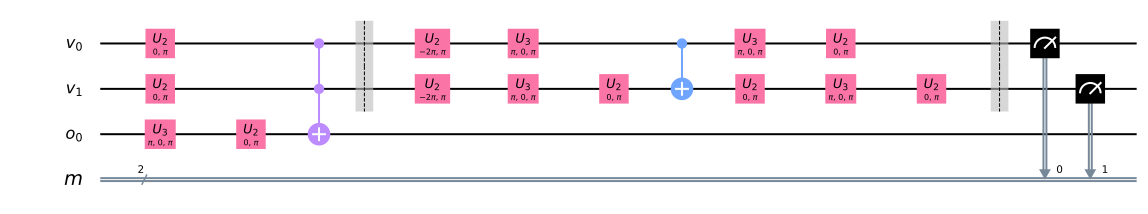

In [14]:
from qiskit.compiler import transpile

# transpile the circuit for ibmq_16_melbourne
#grover_compiled = transpile(result['circuit'], backend=device, optimization_level=3)
grover_compiled = grover.construct_circuit(measurement=True)


print('gates = ', grover_compiled.count_ops())
print('depth = ', grover_compiled.depth())

grover_compiled.draw('mpl')

Job Status: job has successfully run


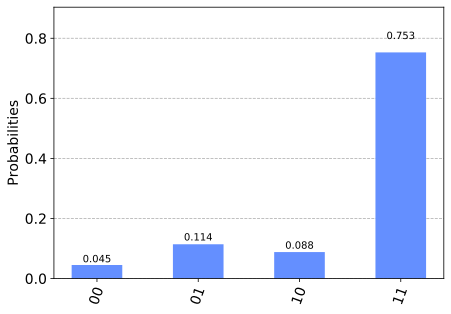

In [15]:
from qiskit.tools.monitor import job_monitor
from qiskit import execute
job = execute(grover_compiled, backend=device, shots=6000)
job_monitor(job, interval = 2)

plot_histogram(job.result().get_counts())

In [16]:
counts = job.result().get_counts()
print(counts)

"""I know this is sloppy but it works"""
ordered_counts = [
    counts.get('00', 0),
    counts.get('01', 0),
    counts.get('10', 0),
    counts.get('11', 0)
]
print(ordered_counts)

print()

ai_probabilities = counts_to_probabilities(ordered_counts)
print(ai_probabilities)

print()

ordered_counts.pop()
ai_action_probabilities = counts_to_probabilities(ordered_counts)
print(ai_action_probabilities)

{'01': 684, '11': 4518, '00': 270, '10': 528}
[270, 684, 528, 4518]

[0.045, 0.159, 0.247, 1.0]

[0.18218623481781376, 0.6437246963562753, 1.0]


In [22]:
random_selection(ai_probabilities, debug=True)

0.12828111369804673 yields 1


1

In [23]:
game_over = False
num_to_throw = {
    0: 'rock',
    1: 'paper',
    2: 'scissors'
}

points_to_win = 5
player_points = 0
grover_points = 0

debug_rng = False

while(not game_over):
    
    player_action = ""
    while(player_action == ""):
        #player_action = input("Rock, paper, or scissors? ")
        player_action = "s"[0]
        if(not (player_action in ['r', 'p', 's', 'e'])):
            player_action = ""

    if(player_action == 'e'):
        print("You give up...")
        game_over = True
        
    else:
        ai_action_type = random_selection(ai_probabilities, debug=debug_rng)

        if(ai_action_type == 0):
            print("Grover pulls a gun! *BANG*")
            print("You appear to have died...")
            print()
            print("Incidentally, that means Grover wins.")
            #game_over = True
        elif(ai_action_type == 1):
            print("Grover laughs histerically!")
            print("(You seem to have lost this round...)")
            grover_points += 1
        elif(ai_action_type == 2):
            print("Grover forgot the score... oh, he remembered it again!")
            print("(You seem to have lost a point...)")
            player_points -= 1
        elif(ai_action_type == 3):
            ai_action_name = num_to_throw.get(
                random_selection(ai_action_probabilities, debug=debug_rng)
            )
            print(f"Grover throws {ai_action_name}!")
            ai_action = ai_action_name[0]

            if(ai_action == player_action):
                print("It's a draw!")
            elif((ai_action == 'r' and player_action == 'p') or
                 (ai_action == 'p' and player_action == 's') or
                 (ai_action == 's' and player_action == 'r')):
                print("You win the round!")
                player_points += 1
            else:
                print("Grover wins the round!")
                grover_points += 1


    if(not game_over):
        print()
        if(player_points >= points_to_win):
            print(f"You have {player_points}, so you win the game!")
            print("Grover congratulates you on your hard-fought victory.")
            game_over = True
        elif(grover_points >= points_to_win):
            print(f"Grover has {grover_points}, so he wins the game.")
            print("Grover smiles with glee!")
            game_over = True
        else:
            print(f"You have {player_points} points, and Grover has {grover_points}")
        
        print()

Grover throws paper!
You win the round!

You have 1 points, and Grover has 0

Grover throws paper!
You win the round!

You have 2 points, and Grover has 0

Grover throws scissors!
It's a draw!

You have 2 points, and Grover has 0

Grover throws paper!
You win the round!

You have 3 points, and Grover has 0

Grover laughs histerically!
(You seem to have lost this round...)

You have 3 points, and Grover has 1

Grover throws scissors!
It's a draw!

You have 3 points, and Grover has 1

Grover throws scissors!
It's a draw!

You have 3 points, and Grover has 1

Grover throws rock!
Grover wins the round!

You have 3 points, and Grover has 2

Grover throws paper!
You win the round!

You have 4 points, and Grover has 2

Grover throws scissors!
It's a draw!

You have 4 points, and Grover has 2

Grover throws rock!
Grover wins the round!

You have 4 points, and Grover has 3

Grover throws paper!
You win the round!

You have 5, so you win the game!
Grover congratulates you on your hard-fought vic